Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Tutorial #2:  Deploy an image classification model in Azure Container Instance (ACI)

This tutorial is **part two of a two-part tutorial series**. In the [previous tutorial](img-classification-part1-training.ipynb), you trained machine learning models and then registered a model in your workspace on the cloud.  

Now, you're ready to deploy the model as a web service in [Azure Container Instances](https://docs.microsoft.com/azure/container-instances/) (ACI). A web service is an image, in this case a Docker image, that encapsulates the scoring logic and the model itself. 

In this part of the tutorial, you use Azure Machine Learning service (Preview) to:

> * Set up your testing environment
> * Retrieve the model from your workspace
> * Test the model locally
> * Deploy the model to ACI
> * Test the deployed model

ACI is a great solution for testing and understanding the workflow. For scalable production deployments, consider using Azure Kubernetes Service. For more information, see [how to deploy and where](https://docs.microsoft.com/azure/machine-learning/service/how-to-deploy-and-where).


## Prerequisites

Complete the model training in the [Tutorial #1: Train an image classification model with Azure Machine Learning](train-models.ipynb) notebook.  



In [ ]:
# If you did NOT complete the tutorial, you can instead run this cell 
# This will register a model and download the data needed for this tutorial
# These prerequisites are created in the training tutorial
# Feel free to skip this cell if you completed the training tutorial 

# register a model
from azureml.core import Workspace
ws = Workspace.from_config()

from azureml.core.model import Model

model_name = "sklearn_mnist"
model = Model.register(model_path="sklearn_mnist_model.pkl",
                        model_name=model_name,
                        tags={"data": "mnist", "model": "classification"},
                        description="Mnist handwriting recognition",
                        workspace=ws)

# download test data
import os
import urllib.request

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok = True)


urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename=os.path.join(data_folder, 'test-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename=os.path.join(data_folder, 'test-labels.gz'))

## Set up the environment

Start by setting up a testing environment.

### Import packages

Import the Python packages needed for this tutorial.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
import azureml.core

# display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.23


### Retrieve the model

You registered a model in your workspace in the previous tutorial. Now, load this workspace and download the model to your local directory.

In [2]:
from azureml.core import Workspace
from azureml.core.model import Model
import os 
ws = Workspace.from_config()
model=Model(ws, 'sklearn_mnist')

model.download(target_dir=os.getcwd(), exist_ok=True)

# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "sklearn_mnist_model.pkl")

os.stat(file_path)

Found the config file in: C:\Users\styoung\Documents\GitHub\CalgaryAirlift\Day3_Operationalization\.azureml\config.json


os.stat_result(st_mode=33206, st_ino=10133099161866794, st_dev=839775639, st_nlink=1, st_uid=0, st_gid=0, st_size=63670, st_atime=1557841020, st_mtime=1557841020, st_ctime=1557835867)

## Test model locally

Before deploying, make sure your model is working locally by:
* Loading test data
* Predicting test data
* Examining the confusion matrix

### Load test data

Load the test data from the **./data/** directory created during the training tutorial.

In [3]:
from utils import load_data
import os

data_folder = os.path.join(os.getcwd(), 'data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

### Predict test data

Feed the test dataset to the model to get predictions.

In [4]:
import pickle
from sklearn.externals import joblib

clf = joblib.load( os.path.join(os.getcwd(), 'sklearn_mnist_model.pkl'))
y_hat = clf.predict(X_test)

###  Examine the confusion matrix

Generate a confusion matrix to see how many samples from the test set are classified correctly. Notice the mis-classified value for the incorrect predictions.

In [5]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

[[ 960    0    2    1    1    4    6    4    1    1]
 [   0 1111    4    2    0    1    5    1   11    0]
 [  10   11  915   20    9    5   10   13   36    3]
 [   4    0   16  919    2   23    5   11   21    9]
 [   1    4    5    4  917    0    7    3    5   36]
 [   9    2    0   40   11  770   16    7   30    7]
 [   7    3    7    1    5   21  910    1    3    0]
 [   2    8   22    5    7    2    1  945    6   30]
 [  10   13    6   22   14   25    7   12  853   12]
 [   6    8    2   14   32   13    0   27   14  893]]
Overall accuracy: 0.9193


Use `matplotlib` to display the confusion matrix as a graph. In this graph, the X axis represents the actual values, and the Y axis represents the predicted values. The color in each grid represents the error rate. The lighter the color, the higher the error rate is. For example, many 5's are mis-classified as 3's. Hence you see a bright grid at (5,3).

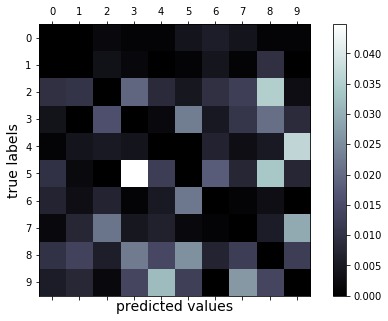

In [6]:
# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

## Deploy as web service

Once you've tested the model and are satisfied with the results, deploy the model as a web service hosted in ACI. 

To build the correct environment for ACI, provide the following:
* A scoring script to show how to use the model
* An environment file to show what packages need to be installed
* A configuration file to build the ACI
* The model you trained before

### Create scoring script

Create the scoring script, called score.py, used by the web service call to show how to use the model.

You must include two required functions into the scoring script:
* The `init()` function, which typically loads the model into a global object. This function is run only once when the Docker container is started. 

* The `run(input_data)` function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats are supported.


In [7]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = Model.get_model_path('sklearn_mnist')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Overwriting score.py


### Create environment file

Next, create an environment file, called myenv.yml, that specifies all of the script's package dependencies. This file is used to ensure that all of those dependencies are installed in the Docker image. This model needs `scikit-learn` and `azureml-sdk`.

In [8]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

Review the content of the `myenv.yml` file.

In [9]:
with open("myenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will

# be automatically provisioned for runs with userManagedDependencies=False.


# Details about the Conda environment file format:

# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually


name: project_environment
dependencies:
  # The python interpreter version.

  # Currently Azure ML only supports 3.5.2 and later.

- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.

  - azureml-defaults
- scikit-learn



### Create configuration file

Create a deployment configuration file and specify the number of CPUs and gigabyte of RAM needed for your ACI container. While it depends on your model, the default of 1 core and 1 gigabyte of RAM is usually sufficient for many models. If you feel you need more later, you would have to recreate the image and redeploy the service.

In [10]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "MNIST",  "method" : "sklearn"}, 
                                               description='Predict MNIST with sklearn')

### Deploy in ACI
Estimated time to complete: **about 7-8 minutes**

Configure the image and deploy. The following code goes through these steps:

1. Build an image using:
   * The scoring file (`score.py`)
   * The environment file (`myenv.yml`)
   * The model file
1. Register that image under the workspace. 
1. Send the image to the ACI container.
1. Start up a container in ACI using the image.
1. Get the web service HTTP endpoint.

In [11]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

# configure the image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="myenv.yml")

service = Webservice.deploy_from_model(workspace=ws,
                                       name='sklearn-mnist-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)

 print(service.scoring_uri)

Creating image
Image creation operation finished for image sklearn-mnist-svc:1, operation "Succeeded"
Creating service
Running......................
SucceededACI service creation operation finished, operation "Succeeded"
Wall time: 6min 49s


In [17]:
#Steve Young Added additional code as the NameError: name 'service' is not defined
from azureml.core.webservice import Webservice
service_name = 'sklearn-mnist-svc'
# Retrieve existing service
service = Webservice(name = service_name, workspace = ws)
print(service.scoring_uri)

http://52.249.200.17:80/score


Get the scoring web service's HTTP endpoint, which accepts REST client calls. This endpoint can be shared with anyone who wants to test the web service or integrate it into an application.

In [15]:
print(service.scoring_uri)
print(service.name)
 

NameError: name 'service' is not defined

In [ ]:
#Update the new model
from azureml.core.webservice import Webservice
from azureml.core.model import Model

import os 
ws = Workspace.from_config()

model_name = "sklearn_mnist"
model = Model.register(model_path="sklearn_mnist_model.pkl",
                        model_name=model_name,
                        tags={"data": "mnist", "model": "classification"},
                        description="Mnist handwriting recognition",
                        workspace=ws)

# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "sklearn_mnist_model.pkl")

    
service_name = 'sklearn-mnist-svc'
# Retrieve existing service
service = Webservice(name = service_name, workspace = ws)
print(service.scoring_uri)


# Update to new model(s)
#service.update(models=[Model])
print(service.state)
print(service.get_logs())

## Test deployed service

Earlier you scored all the test data with the local version of the model. Now, you can test the deployed model with a random sample of 30 images from the test data.  

The following code goes through these steps:
1. Send the data as a JSON array to the web service hosted in ACI. 

1. Use the SDK's `run` API to invoke the service. You can also make raw calls using any HTTP tool such as curl.

1. Print the returned predictions and plot them along with the input images. Red font and inverse image (white on black) is used to highlight the misclassified samples. 

 Since the model accuracy is high, you might have to run the following code a few times before you can see a misclassified sample.

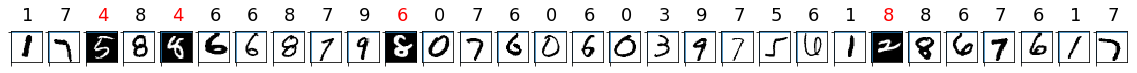

In [18]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

You can also send raw HTTP request to test the web service.

In [19]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://52.249.200.17:80/score
label: 4
prediction: [4]


## Clean up resources

To keep the resource group and workspace for other tutorials and exploration, you can delete only the ACI deployment using this API call:

In [ ]:
service.delete()


If you're not going to use what you've created here, delete the resources you just created with this quickstart so you don't incur any charges. In the Azure portal, select and delete your resource group. You can also keep the resource group, but delete a single workspace by displaying the workspace properties and selecting the Delete button.


## Next steps

In this Azure Machine Learning tutorial, you used Python to:

> * Set up your testing environment
> * Retrieve the model from your workspace
> * Test the model locally
> * Deploy the model to ACI
> * Test the deployed model
 
You can also try out the [regression tutorial](regression-part1-data-prep.ipynb).